# 🌫️ Pemodelan Clustering — Deep Dive Fuzzy C-Means (FCM)

### Jembatan Konseptual: Dari Hard ke Soft Clustering

Selamat datang di bagian **2.b**, bagian terakhir dari seri pemodelan kita. Di bagian sebelumnya, kita telah menguasai **K-Means**, sebuah algoritma *hard clustering* di mana setiap data menjadi anggota eksklusif dan tegas dari **satu** cluster saja.

Namun, bagaimana jika data berada di 'area abu-abu' di antara dua kelompok? Di sinilah **Fuzzy C-Means (FCM)** bersinar. FCM adalah metode *soft clustering*.

### Filosofi Fuzzy C-Means: "Tingkat Keanggotaan"

> **Analogi Sederhana:** Bayangkan genre musik. Sebuah lagu bisa jadi 80% Pop dan 20% Rock. FCM mencoba menangkap nuansa ini dengan memberikan **tingkat keanggotaan (membership degree)** kepada setiap titik data untuk setiap cluster yang ada.

Hasil dari FCM bukanlah label tunggal, melainkan sebuah matriks keanggotaan yang menunjukkan probabilitas setiap titik data menjadi bagian dari setiap cluster. Ini sangat berguna untuk memahami ketidakpastian dan tumpang tindih dalam data.

Di notebook ini, kita akan menerapkan FCM pada dataset Iris, memahami outputnya yang unik, dan memvisualisasikan hasil "fuzzy"-nya.

### Langkah 1: Setup Mandiri & Persiapan Data

Sebagai notebook mandiri, sel pertama ini akan menangani semua yang kita butuhkan: mengimpor pustaka, menginstal `scikit-fuzzy` jika belum ada, memuat data mentah, dan melakukan penskalaan fitur.

In [1]:
# Instalasi pustaka scikit-fuzzy jika belum ada
!pip install -U scikit-fuzzy

# =======================================================
# SETUP MANDIRI UNTUK PEMODELAN FUZZY C-MEANS
# =======================================================

# 1. Import Pustaka
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.datasets import load_iris
from sklearn.preprocessing import StandardScaler
import skfuzzy as fuzz

print("Pustaka yang dibutuhkan telah diimpor.")

# 2. Memuat dan Membuat DataFrame Awal
iris = load_iris()
df_iris = pd.DataFrame(data=iris.data, columns=['sepal_length', 'sepal_width', 'petal_length', 'petal_width'])
df_iris['true_species'] = [iris.target_names[i] for i in iris.target] # Untuk evaluasi akhir
print("Dataset Iris mentah berhasil dibuat.")

# 3. Pra-Pemrosesan: Penskalaan Fitur
# Sama seperti K-Means, FCM sensitif terhadap skala data.
print("\nMemulai pra-pemrosesan (penskalaan)... ")
features = df_iris[['sepal_length', 'sepal_width', 'petal_length', 'petal_width']]
scaler = StandardScaler()
X_scaled = scaler.fit_transform(features)
print("Penskalaan fitur selesai.")

# 4. Persiapan Data untuk Pustaka skfuzzy
# Pustaka scikit-fuzzy memerlukan data dengan fitur sebagai baris dan sampel sebagai kolom (transpos)
X_transposed = X_scaled.T


[notice] A new release of pip is available: 24.3.1 -> 25.1.1
[notice] To update, run: python3 -m pip install --upgrade pip


Pustaka yang dibutuhkan telah diimpor.
Dataset Iris mentah berhasil dibuat.

Memulai pra-pemrosesan (penskalaan)... 
Penskalaan fitur selesai.


### Langkah 2: Membangun & Melatih Model Fuzzy C-Means

Kita akan melatih model FCM dengan `c=3` cluster (berdasarkan analisis Elbow Method kita di K-Means). Parameter penting lainnya adalah `m`, yaitu *fuzziness parameter*. Nilai `m > 1` menentukan tingkat 'fuzzy' dari sebuah cluster. Nilai `m=2` adalah yang paling umum digunakan.

In [2]:
# Menentukan parameter FCM
n_clusters = 3
m = 2 # Fuzziness parameter (standar)
error = 0.005 # Batas error untuk berhenti
max_iter = 1000 # Maksimum iterasi

# Melatih model FCM
# Fungsi ini mengembalikan beberapa nilai, kita fokus pada centroid (cntr) dan matriks keanggotaan (u)
cntr, u, u0, d, jm, p, fpc = fuzz.cluster.cmeans(
    X_transposed, 
    c=n_clusters, 
    m=m, 
    error=error, 
    maxiter=max_iter, 
    seed=42
)

# Mendapatkan label cluster 'hard' dengan mencari tingkat keanggotaan tertinggi untuk setiap titik data
predicted_labels = np.argmax(u, axis=0)

# Tambahkan label prediksi ke DataFrame utama
df_iris['fcm_cluster'] = predicted_labels

print("Pelatihan model Fuzzy C-Means selesai.")
print(f"Bentuk matriks keanggotaan (u): {u.shape}")
print(f"Bentuk centroid (cntr): {cntr.shape}")

Pelatihan model Fuzzy C-Means selesai.
Bentuk matriks keanggotaan (u): (3, 150)
Bentuk centroid (cntr): (3, 4)


### Langkah 3: Visualisasi Hasil Clustering

Meskipun FCM menghasilkan keanggotaan yang "fuzzy", cara termudah untuk memvisualisasikan hasilnya adalah dengan memberikan setiap titik data ke cluster di mana ia memiliki keanggotaan tertinggi (ini disebut *hard assignment*).

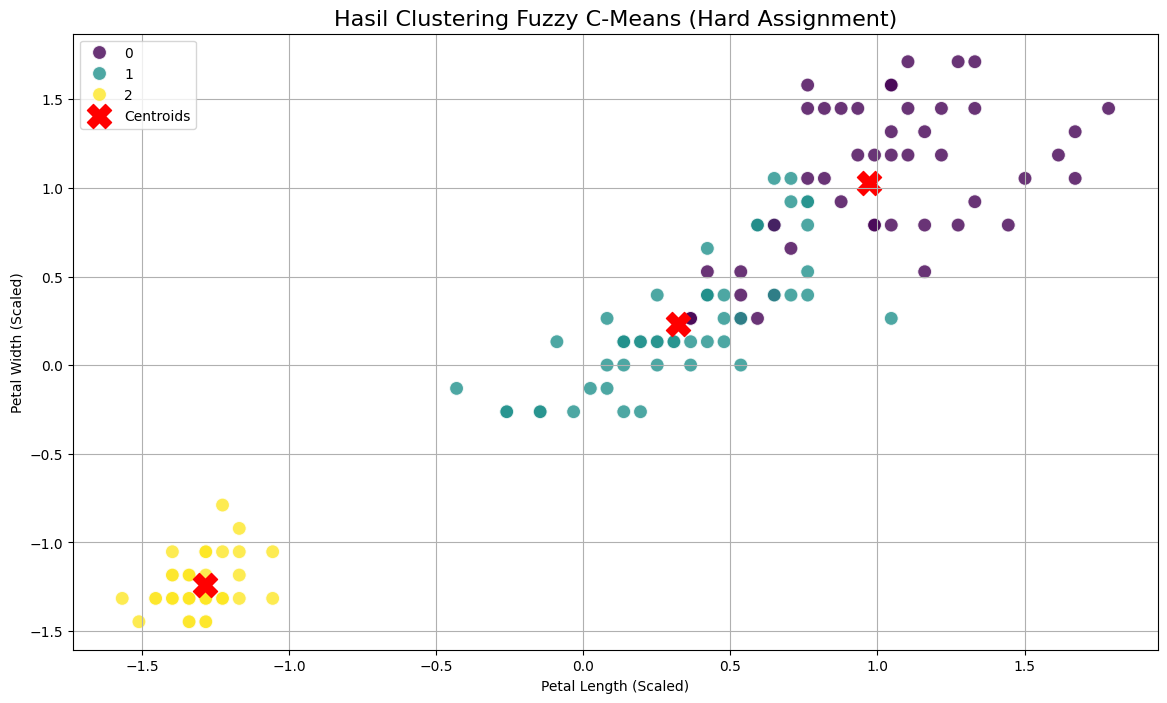

In [3]:
# Visualisasi hasil clustering pada data yang telah diskalakan
df_scaled_pd = pd.DataFrame(X_scaled, columns=features.columns)
df_scaled_pd['fcm_cluster'] = predicted_labels

plt.figure(figsize=(14, 8))
sns.scatterplot(data=df_scaled_pd, x='petal_length', y='petal_width', hue='fcm_cluster', 
                palette='viridis', s=100, alpha=0.8, legend='full')

# Plot centroid
plt.scatter(cntr[:, 2], cntr[:, 3], s=300, c='red', marker='X', label='Centroids')
plt.title('Hasil Clustering Fuzzy C-Means (Hard Assignment)', fontsize=16)
plt.xlabel('Petal Length (Scaled)')
plt.ylabel('Petal Width (Scaled)')
plt.legend()
plt.grid(True)
plt.show()

Secara visual, hasil *hard assignment* dari FCM sangat mirip dengan hasil K-Means, yang menunjukkan bahwa kedua algoritma berhasil menemukan struktur dasar yang sama.

### Langkah 4: "Deep Dive" — Menganalisis Tingkat Keanggotaan (Membership)

Di sinilah kekuatan sesungguhnya dari FCM terletak. Mari kita selidiki matriks keanggotaan `u` untuk melihat titik-titik data yang "bingung" atau memiliki keanggotaan yang terbagi.

In [4]:
# Membuat DataFrame dari matriks keanggotaan
df_membership = pd.DataFrame(u.T, columns=[f'Cluster_{i}_Prob' for i in range(n_clusters)])

# Gabungkan dengan data asli
df_iris_full_analysis = pd.concat([df_iris, df_membership], axis=1)

print("--- Data dengan Tingkat Keanggotaan Cluster ---")
display(df_iris_full_analysis.head())

# Cari titik data yang paling 'fuzzy' (tidak pasti)
# Yaitu, titik di mana probabilitas keanggotaan tertingginya tidak terlalu dominan (misal < 75%)
max_membership = df_iris_full_analysis[[f'Cluster_{i}_Prob' for i in range(n_clusters)]].max(axis=1)
fuzzy_points = df_iris_full_analysis[max_membership < 0.75]

print(f"\n{len(fuzzy_points)} titik data teridentifikasi sebagai 'fuzzy' (keanggotaan tertinggi < 75%):")
display(fuzzy_points)

--- Data dengan Tingkat Keanggotaan Cluster ---


,sepal_length,sepal_width,petal_length,petal_width,true_species,fcm_cluster,Cluster_0_Prob,Cluster_1_Prob,Cluster_2_Prob
0,5.1,3.5,1.4,0.2,setosa,2,0.003132,0.005290,0.991578
1,4.9,3.0,1.4,0.2,setosa,2,0.051865,0.119296,0.828839
2,4.7,3.2,1.3,0.2,setosa,2,0.023331,0.047340,0.929328
3,4.6,3.1,1.5,0.2,setosa,2,0.041318,0.089245,0.869438
4,5.0,3.6,1.4,0.2,setosa,2,0.010007,0.016038,0.973955



50 titik data teridentifikasi sebagai 'fuzzy' (keanggotaan tertinggi < 75%):


,sepal_length,sepal_width,petal_length,petal_width,true_species,fcm_cluster,Cluster_0_Prob,Cluster_1_Prob,Cluster_2_Prob
8,4.4,2.9,1.4,0.2,setosa,2,0.079130,0.180699,0.740171
14,5.8,4.0,1.2,0.2,setosa,2,0.116736,0.138439,0.744826
15,5.7,4.4,1.5,0.4,setosa,2,0.179930,0.186778,0.633292
33,5.5,4.2,1.4,0.2,setosa,2,0.129259,0.148515,0.722226
41,4.5,2.3,1.3,0.3,setosa,2,0.154897,0.389019,0.456084
50,7.0,3.2,4.7,1.4,versicolor,0,0.732373,0.206547,0.061080
51,6.4,3.2,4.5,1.5,versicolor,0,0.619497,0.313200,0.067303
54,6.5,2.8,4.6,1.5,versicolor,1,0.401129,0.558605,0.040266
56,6.3,3.3,4.7,1.6,versicolor,0,0.657904,0.270123,0.071974
57,4.9,2.4,3.3,1.0,versicolor,1,0.143521,0.658380,0.198099


#### Visualisasi Fuzziness

Cara yang elegan untuk memvisualisasikan ketidakpastian ini adalah dengan menggunakan tingkat keanggotaan tertinggi untuk mengatur transparansi (`alpha`) dari setiap titik. Titik yang pasti akan terlihat solid, sedangkan titik yang "fuzzy" akan terlihat transparan.

/tmp/ipykernel_17651/3406514574.py:7: UserWarning: *c* argument looks like a single numeric RGB or RGBA sequence, which should be avoided as value-mapping will have precedence in case its length matches with *x* & *y*.  Please use the *color* keyword-argument or provide a 2D array with a single row if you intend to specify the same RGB or RGBA value for all points.
  plt.scatter(


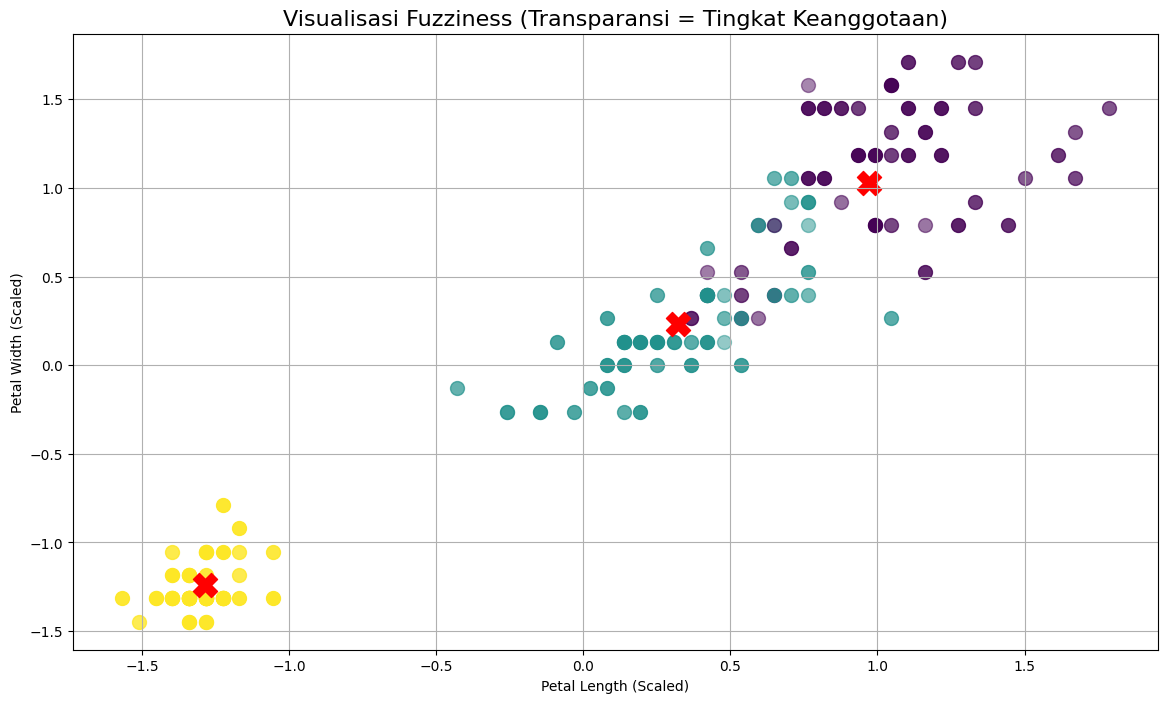

In [5]:
# Dapatkan tingkat keanggotaan tertinggi untuk setiap titik
max_u = np.max(u, axis=0)

plt.figure(figsize=(14, 8))
# Loop melalui setiap titik untuk memplot dengan alpha yang sesuai
for i in range(len(X_scaled)):
    plt.scatter(
        X_scaled[i, 2], # petal_length (scaled)
        X_scaled[i, 3], # petal_width (scaled)
        c=plt.cm.viridis(predicted_labels[i] / (n_clusters - 1)), # Warna berdasarkan cluster
        alpha=max_u[i], # Transparansi berdasarkan kepastian
        s=100
    )

plt.scatter(cntr[:, 2], cntr[:, 3], s=300, c='red', marker='X', label='Centroids')
plt.title('Visualisasi Fuzziness (Transparansi = Tingkat Keanggotaan)', fontsize=16)
plt.xlabel('Petal Length (Scaled)')
plt.ylabel('Petal Width (Scaled)')
plt.grid(True)
plt.show()

**Analisis Visualisasi Fuzziness:**
Pada grafik ini, titik-titik yang warnanya paling solid adalah titik yang keanggotaannya di satu cluster sangat tinggi (mendekati 100%). Sebaliknya, titik-titik yang tampak pudar atau transparan adalah titik-titik "fuzzy" yang kita identifikasi sebelumnya. Terlihat jelas bahwa titik-titik ini berada di perbatasan antara cluster `versicolor` dan `virginica`, yang secara akurat menangkap sifat tumpang tindih dari data asli.

### Penutup dan Kesimpulan Akhir Proyek

Dengan selesainya notebook ini, kita telah menyelesaikan perjalanan lengkap kita melalui berbagai teknik pemodelan. Kita telah menjelajahi:

1.  **Klasifikasi (Supervised Learning):** Di mana kita melatih model (Naive Bayes, KNN, Decision Tree) untuk memprediksi label yang sudah ada. Tujuannya adalah akurasi prediksi.
2.  **Clustering (Unsupervised Learning):** Di mana kita meminta model (K-Means, Fuzzy C-Means) untuk menemukan struktur atau kelompok tersembunyi di dalam data tanpa menggunakan label. Tujuannya adalah penemuan pola.

Kita melihat bagaimana K-Means memberikan penugasan yang tegas (*hard clustering*), sementara Fuzzy C-Means memberikan penugasan yang bernuansa (*soft clustering*), yang sangat berguna untuk memahami data yang ambigu.

Perjalanan dari pemahaman data mentah hingga penerapan berbagai jenis model ini menunjukkan kekuatan dan fleksibilitas dari ilmu data. Setiap algoritma memberikan lensa yang berbeda untuk melihat dan memahami dataset yang sama, membekali kita dengan wawasan yang lebih kaya dan komprehensif.